In [19]:
%matplotlib inline

import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
import random
from pysar.utils.solvers import l1reg_lstsq
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

# specified time-series
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
tbase = np.array(ts_obj.tbase)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt


In [4]:
## equation (S2) - Exmaple design matrix C for the interferograms triplets.
date_list = ts_obj.dateList[:8]
date12_list = pnet.select_pairs_sequential(date_list, num_connection=3, date12_format='YYYYMMDD_YYYYMMDD')
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(int)
print(C.shape)
print(C)

(16, 18)
[[ 1 -1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 -1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 -1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 -1  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 -1  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 -1  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 -1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 -1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 -1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 -1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0 -1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1]]


number of ifgrams: 475
number of triplets: 940
ifgram with unwrap error: 0.2
unwrap error jump in 2*pi*(-5, 5): 
number of ifgrams with unwrap error: 95
max perpendicular baseline: 214.31 m
max temporal      baseline: 120.0 days


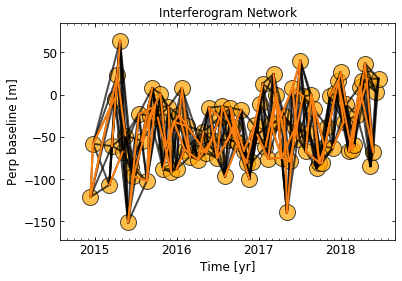

In [70]:
## Simulate interferograms with unwrapping errors

# temp/spatial baseline
#date_list = ts_obj.dateList[:4] + ts_obj.dateList[7:10]
#pbase = ts_obj.pbase[:4].tolist() + ts_obj.pbase[7:10].tolist()
date_list = ts_obj.dateList#[:50]
pbase = ts_obj.pbase#[:50].tolist()
dates = ptime.date_list2vector(date_list)[0]

# network setup
date12_list = pnet.select_pairs_sequential(date_list, num_connection=5, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of ifgrams: {}'.format(num_ifgram))
print('number of triplets: {}'.format(C.shape[0]))

# simulate ifgram without unwrap error
ifgram_sim = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid, L=3*9, num_sample=1, baseline_file='bl_list.txt', sensor_name=sensor_name, inc_angle=inc_angle)[0].flatten()
# add unwrap error
#idx_ifg_err = random.sample(list(range(len(ifgram_sim))), 5)
#ifgram_err = np.array(ifgram_sim, dtype=np.float32)
#ifgram_err[idx_ifg_err] += 2.*np.pi*2.
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram_sim, percentage=0.2, Nmax=5, print_msg=True)

# plot
fig, ax = plt.subplots()
pp.plot_network(ax, date12_list, date_list, pbase)
# plot interferometric pairs with error
for date12 in np.array(date12_list)[idx_ifg_err]:
    date1, date2 = date12.split('_')
    idx1 = date_list.index(date1)
    idx2 = date_list.index(date2)
    x = [dates[idx1], dates[idx2]]
    y = [pbase[idx1], pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
# axis format
pp.auto_adjust_xaxis_date(ax, dates, fontsize=font_size)
ax.set_xlabel('Time [yr]', fontsize=font_size)
ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
plt.show()

In [71]:
ifgram = np.array(ifgram_err)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(float)
num_tri, num_ifgram = C.shape
ifgram = ifgram.reshape(num_ifgram, -1)

# integer ambiguity of the closure phase
closure_pha = np.dot(C, ifgram)
closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))

Error percentage: 0.20 -> 0.00


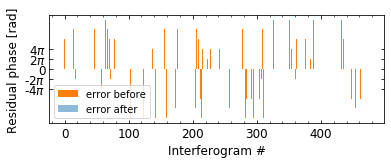

In [72]:
## Option 1 - LASSO using cvxopt - fast
from cvxopt import matrix, sparse
A = matrix(-C)
b = matrix(closure_int)
U = np.round(l1reg_lstsq(A, b, lambd=1e-2))

# corrected interferogram
ifgram_cor = ifgram + 2*np.pi*U
ifgram_cor = ifgram_cor.flatten()

# error percentage
perc0 = np.sum(np.abs(ifgram_err - ifgram_sim) > 0.1) / num_ifgram
perc1 = np.sum(np.abs(ifgram_cor - ifgram_sim) > 0.1) / num_ifgram
print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))

# plot
fig, ax = plt.subplots(figsize=[6, 2])
x_list = np.arange(num_ifgram)
ax.bar(x_list, ifgram_err - ifgram_sim, color=pp.mplColors[1], label='error before')
ax.bar(x_list, ifgram_cor - ifgram_sim, color=pp.mplColors[0], label='error after', alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
plt.legend()
plt.show()

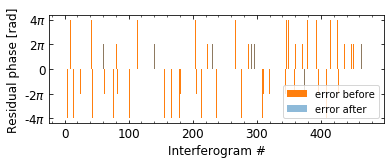

In [16]:
## Option 2 - LASSO using cvxopt - slow
import cvxpy as cp
x = cp.Variable(num_ifgram, integer=False)
lambd = cp.Parameter(nonneg=True)
lambd.value = 1e-2
A = np.array(-C)
b = closure_int.flatten()
obj = cp.Minimize(cp.sum_squares(cp.matmul(A, x) - b) + lambd * cp.norm1(x))
prob = cp.Problem(obj)
prob.solve()

U = np.round(x.value).reshape(num_ifgram, -1)

# corrected interferogram
ifgram_cor = ifgram_err + 2*np.pi*U
ifgram_cor = ifgram_cor.flatten()

# plot
fig, ax = plt.subplots(figsize=[6, 2])
x_list = np.arange(num_ifgram)
ax.bar(x_list, ifgram_err - ifgram_sim, color=pp.mplColors[1], label='error before')
ax.bar(x_list, ifgram_cor - ifgram_sim, color=pp.mplColors[0], label='error after', alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
#ax.set_xlim(0, ifgram.shape[0])
plt.legend()
plt.show()

In [86]:
## Fig. S8 - Fing proper LASSO coefficient alpha in equation (11)
re_generate = False
err_perc = 0.20

alpha_values = np.logspace(-5, 1, 25)
num_value = alpha_values.size
num_rep = 100

for err_perc in [0.1, 0.2, 0.3]:
    pfile = 'lasso_alpha_{:02d}.pickle'.format(int(err_perc * 100))
    if re_generate or not os.path.isfile(pfile):
        print('Finding the LASSO coefficient alpha in equation (11) for file', pfile)
        ds = {}
        ds['alpha'] = alpha_values
        ds['num_error'] = np.zeros(num_value)
        #ds['time'] = np.zeros(num_value)

        prog_bar = ptime.progressBar(maxValue=num_value)
        for i in range(num_value):
            alpha = alpha_values[i]
            num_err = 0
            for j in range(num_rep):
                # prepare b
                ifgram_err = sim.add_unw_err2ifgram(ifgram_sim, percentage=err_perc, Nmax=5, print_msg=False)[0]
                ifgram = np.array(ifgram_err).reshape(num_ifgram, -1)
                closure_pha = np.dot(C, ifgram)
                closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))
                b = matrix(closure_int)
                U = np.round(l1reg_lstsq(A, b, lambd=alpha))
                unw_err = np.round(((ifgram + 2*np.pi*U).flatten() - ifgram_sim) / (2.0 * np.pi))
                num_err += np.sum(unw_err != 0)
            num_err /= num_rep
            ds['num_error'][i] = num_err
            prog_bar.update(i+1, suffix='{:.6f}'.format(alpha))
        prog_bar.close()
    
        # write to pickle file
        with open(pfile, 'wb') as f:
            pickle.dump(ds, f)
        print('saved to pickle file', pfile)
        ds = dict(ds)
print('Done.')

Done.


saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/lasso_alpha.png


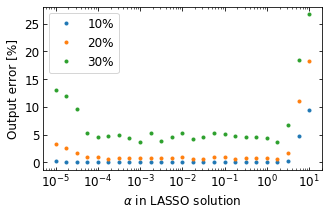

In [113]:
import glob
fig, ax = plt.subplots(figsize=[5, 3])
pfiles = glob.glob('lasso_alpha*pickle')
for pfile in pfiles:
    err_perc = os.path.splitext(pfile)[0].split('_alpha_')[1]
    ds = pickle.load(open(pfile, 'rb'))
    ax.plot(ds['alpha'], ds['num_error']/num_ifgram * 100., '.', label='{}%'.format(err_perc))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=8))
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=8, subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)))
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylabel('Output error [%]', fontsize=font_size)
ax.set_xlabel(r"$\alpha$ in LASSO solution", fontsize=font_size)
ax.set_xscale("log")
ax.legend(fontsize=font_size)

# save
out_file = os.path.join(os.getcwd(), 'lasso_alpha.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

Thus, choose $\alpha$ = 0.01 for the LASSO regression.